In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform 

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
Countrydf=pd.read_csv('Country-data.csv')
Countrydf.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
Countrydf.shape

(167, 10)

In [4]:
Countrydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


## Data Preparation and EDA

In [5]:
# Making basic checks to prep the data before modelling
Countrydf.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [6]:
#No nulls present in any columns

In [7]:
Countrydf.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [8]:
cat_columns='country'
num_columns=list(set(Countrydf.columns)-{'country'})

In [9]:
# According to the data dictionary, health imports and exports columns are expressed in terms of percentage of gdpp.
# So I am converting it back to its actual values for data continuity. 2 Countries might have the same imports% 
# but contrasting gdpp; thus the %values won't account towards a proper analysis.
Countrydf[['health','imports','exports']]=Countrydf[['health','imports','exports']].apply(lambda x:Countrydf['gdpp']*x/100)

#### Bivariate Analysis
- The objective of our analysis is to help identify countries in dire need of help from the NGO.
- Let's try to identify some of them using visualizations.

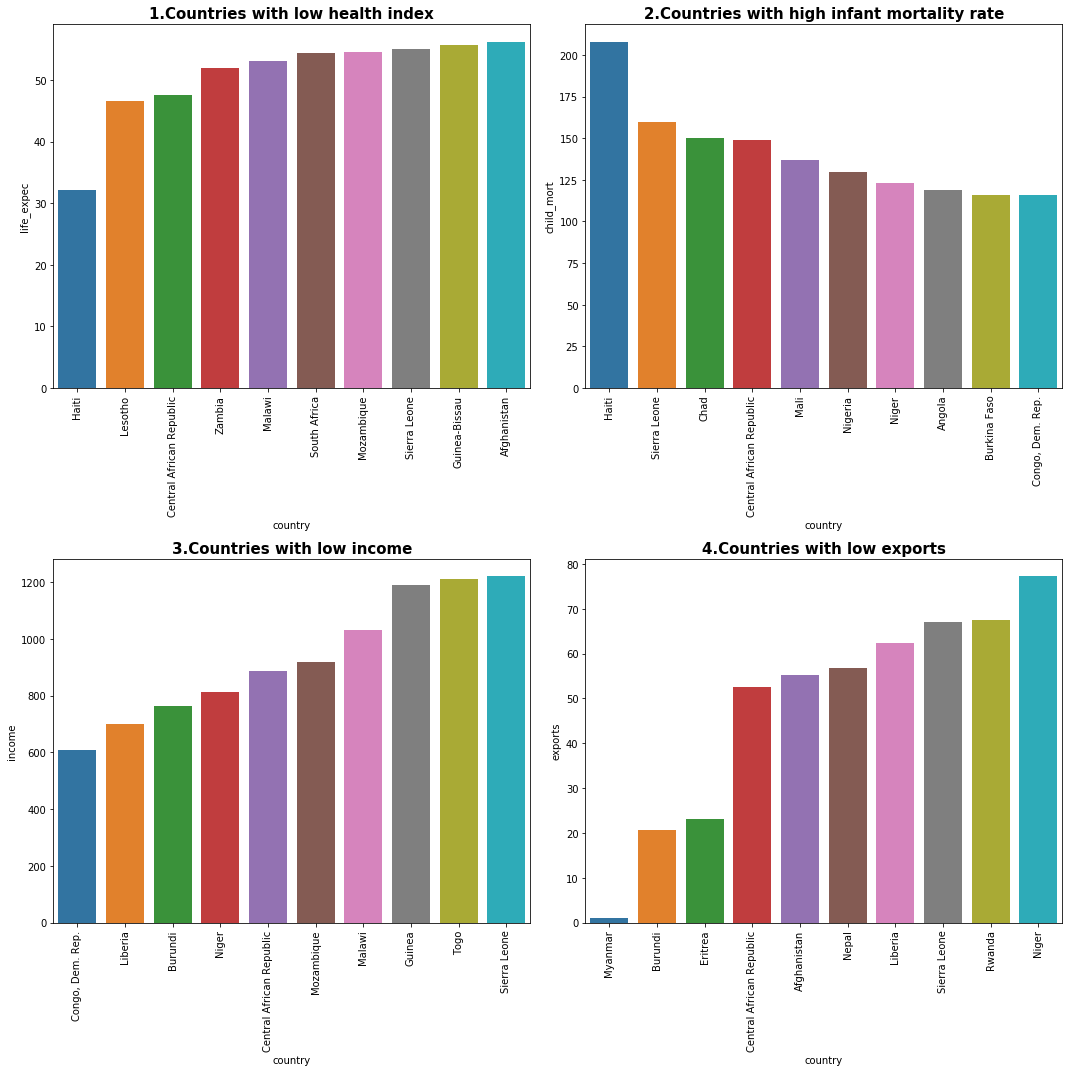

In [10]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
temp=Countrydf.sort_values(by='life_expec',ascending=True).head(10)
sns.barplot(x='country',y='life_expec',data=temp.sort_values(by='life_expec',ascending=True))
plt.xticks(rotation=90)
plt.title('1.Countries with low health index',fontweight="bold",fontsize=15)

plt.subplot(2,2,2)
temp=Countrydf.sort_values(by='child_mort',ascending=False).head(10)
sns.barplot(x='country',y='child_mort',data=temp.sort_values(by='child_mort',ascending=False))
plt.xticks(rotation=90)
plt.title('2.Countries with high infant mortality rate',fontweight="bold",fontsize=15)

plt.subplot(2,2,3)
temp=Countrydf.sort_values(by='income',ascending=True).head(10)
sns.barplot(x='country',y='income',data=temp.sort_values(by='income',ascending=True))
plt.xticks(rotation=90)
plt.title('3.Countries with low income',fontweight="bold",fontsize=15)

plt.subplot(2,2,4)
temp=Countrydf.sort_values(by='exports',ascending=True).head(10)
sns.barplot(x='country',y='exports',data=temp.sort_values(by='exports',ascending=True))
plt.xticks(rotation=90)
plt.title('4.Countries with low exports',fontweight="bold",fontsize=15)

plt.tight_layout()
plt.show()

- Haiti, Lesotho, Central African Republic, Zambia and Malawi are some countries having low heatlth index
- Haiti, Sierra Leone, Chad, Central African Republic, Mali are having high infant mortality rate
- Congo, Liberia, Burundi, Niger, Central African Republic are having low income values
- Myanmar, Burundi, Entrea, Central African Republic have low export numbers

Hence we can clearly deduct that a lot of African Countries are performing very poorly. The main purpose of the clustering model will be to help pin point countries requiring immediate aid.

In [11]:
df=Countrydf.copy()
Countrydf.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


There are significant outliers in all of the columns, which has to be treated before modelling

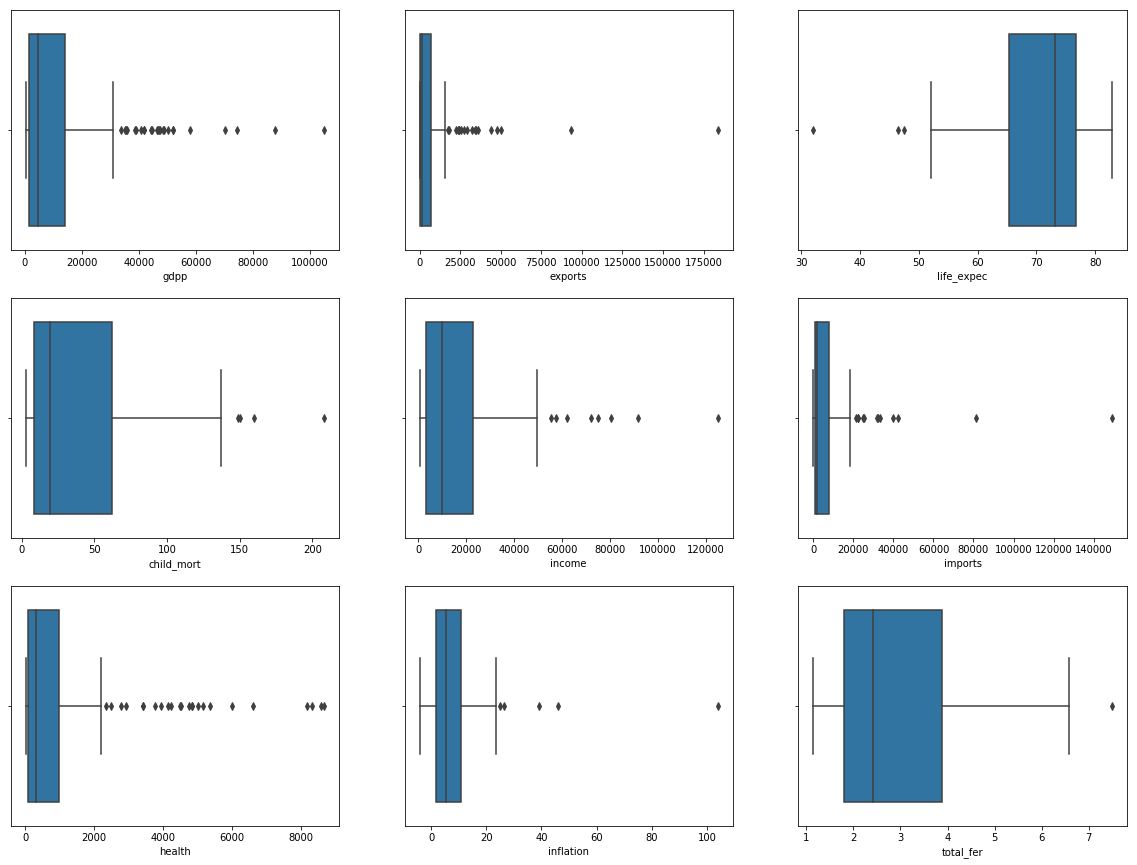

In [12]:
plt.figure(figsize=(20,15))
for i,j in enumerate(num_columns):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=j,data=Countrydf)

Since each record in the dataframe corresponds to different countries, I don't want to miss certain countries by droppinng outliers so I've decided to cap them at 5-95 percentiles.

In [13]:
for i in num_columns:
    p=Countrydf[i].quantile([0.05,0.95]).values #Percentile values
    df[i]=Countrydf[i].apply(lambda x:p[0] if x<=p[0] else p[1] if x>=p[1] else x)

In [14]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,36.808623,5784.478480,954.366191,5142.509689,15755.491018,7.016075,70.830060,2.922389,12003.719162
std,36.193830,8579.136537,1453.198372,6694.383178,14770.353771,6.271398,8.039216,1.438264,15154.443890
min,3.460000,70.468800,26.715920,169.281000,1213.000000,0.183400,55.780000,1.390000,465.900000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000


Majority of the outliers are thereby handled.

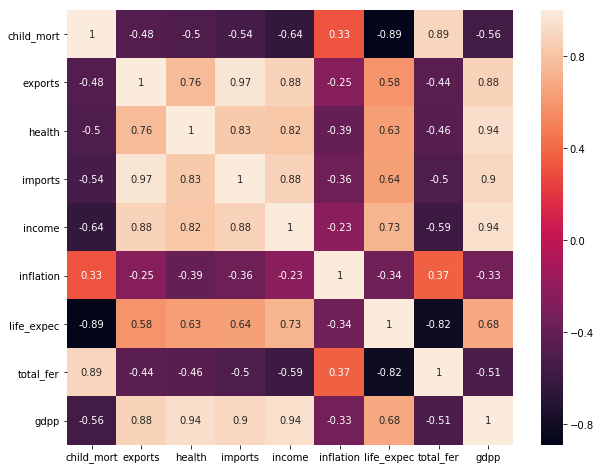

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

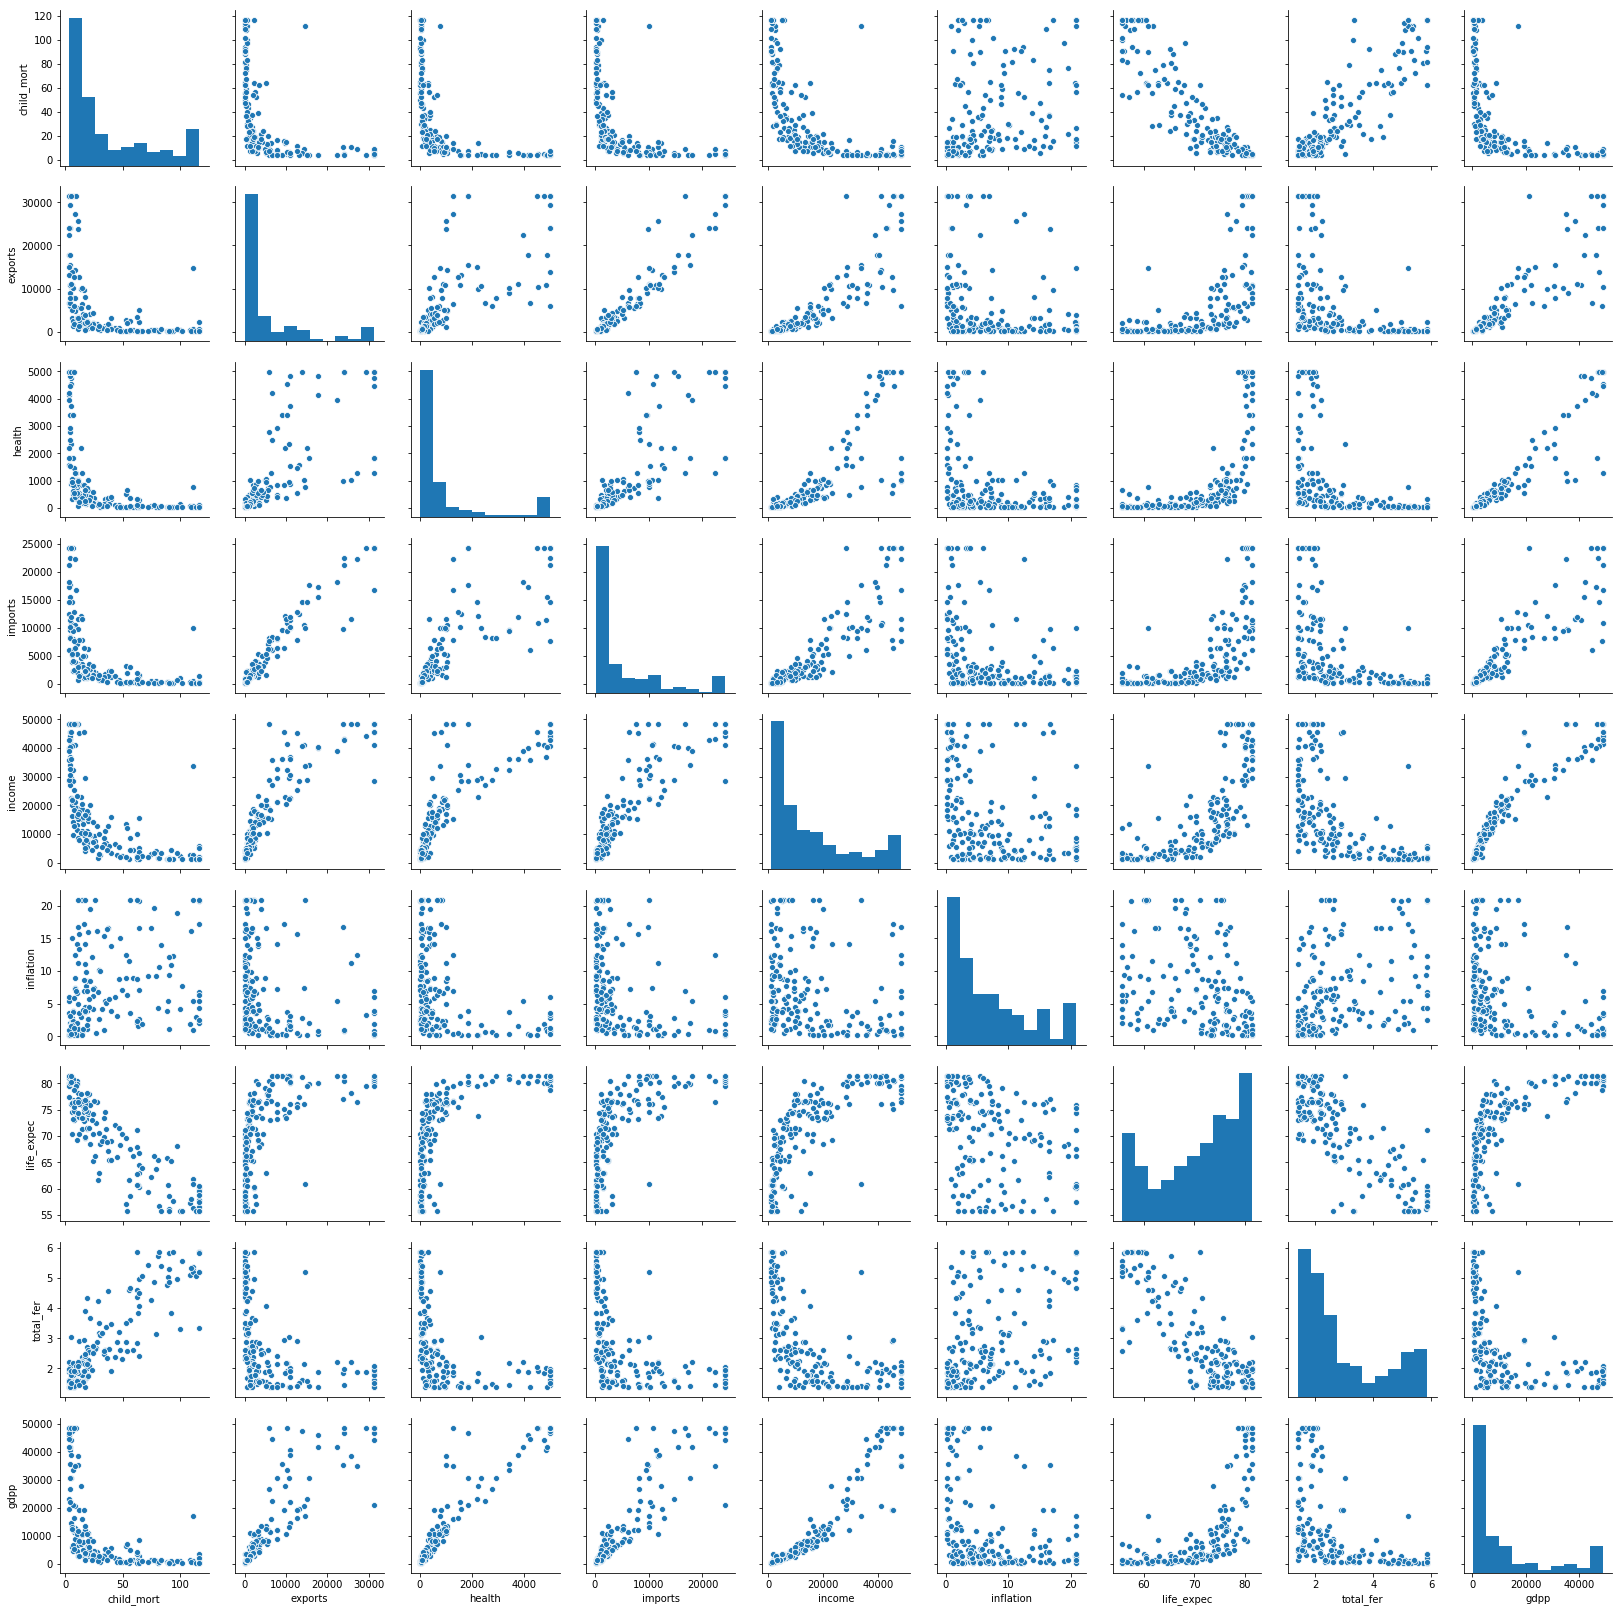

In [16]:
sns.pairplot(df)
plt.show()

- The variables are having decent correlations between them.
- Inflation have comparatively lower correlations with other variables. 
- Life expectation is inversely correlated with child mortality rates and total fertility rates.

## Steps to be done after EDA:
- 1.Scaling
- 2.PCA
- 3.Hopkin's test
- 4.Modelling

### 1. Feature Scaling
PCA(Principal Component Analysis) is performed on the dataset to reduce the dimensionality for our clustering analysis. Most software packages use SVD(Singular Value Decomposition) to compute the principal components and assume that the data is scaled and centred, so it is important to do standardisation/normalisation. There are two common ways of rescaling:
Min-Max scaling
Standardisation (mean-0, sigma-1)
Here, we will use Standardisation Scaling.

In [17]:
df_scaled=df.drop('country',axis=1)
country=df['country']
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df_scaled)
df_scaled

array([[ 1.47958789, -0.66803864, -0.62977844, ..., -1.82530988,
         2.02071786, -0.7578739 ],
       [-0.56002364, -0.54238923, -0.47380714, ...,  0.68245351,
        -0.88733091, -0.52377507],
       [-0.26350403, -0.47604845, -0.53034406, ...,  0.70740638,
        -0.02258739, -0.49928636],
       ...,
       [-0.37435248, -0.56600553, -0.59686482, ...,  0.2832076 ,
        -0.67811877, -0.70777132],
       [ 0.54014725, -0.63033074, -0.61187406, ..., -0.41547275,
         1.21873798, -0.70777132],
       [ 1.28283189, -0.61312123, -0.59935647, ..., -1.8777109 ,
         1.72782086, -0.69784347]])

### 2. PCA
It is evident from the heatmap and pairplots that the variables are having decent-strong correlations between them, which can lead to redudancy during modeling. PCA can be used to reduce the dimensionality of our dataset and help resturcture it into key principal components, which can inturn be used to make the model more meaningful and accurate.

In [18]:
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [19]:
pca.components_

array([[-0.31370269,  0.3507987 ,  0.35117815,  0.36823124,  0.37600029,
        -0.17399218,  0.34308686, -0.29811056,  0.37600871],
       [ 0.48684113,  0.33097569,  0.24315695,  0.26930019,  0.16807187,
         0.20045729, -0.34450382,  0.51847097,  0.25664488],
       [-0.17763592,  0.06865384, -0.13607851, -0.04200452,  0.17010197,
         0.93794124,  0.15426058, -0.10473969, -0.00389912],
       [ 0.02276945, -0.53686278,  0.64515576, -0.38273615,  0.01264167,
         0.10608158,  0.18223721,  0.15311285,  0.28368985],
       [ 0.12839534, -0.08487856,  0.20033804, -0.04421243,  0.07457851,
         0.07932579, -0.67371553, -0.67970463,  0.08046529],
       [ 0.1076401 , -0.12068475, -0.4231057 , -0.38460027,  0.74879481,
        -0.17145666, -0.03640109,  0.06088361,  0.22757439],
       [-0.77529381, -0.03982588,  0.0371735 ,  0.00485008,  0.05733254,
        -0.02440683, -0.50118517,  0.37360537,  0.03574582],
       [-0.05482803,  0.44271452, -0.15457504, -0.49759106, -0

In [20]:
pca.explained_variance_ratio_

array([0.68508868, 0.14727819, 0.09507098, 0.03147493, 0.01636993,
       0.0119143 , 0.00890517, 0.00252245, 0.00137538])

1st principal component is describing nearly 70 percent of the total variance.  
  2nd principal component explains 15% of the total variance

#### Scree-Plot

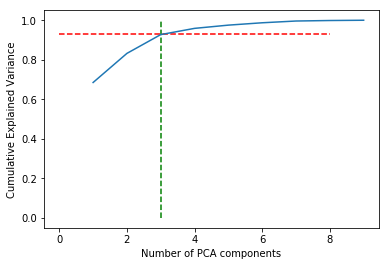

In [21]:
scree=[(i+1,j) for i,j in enumerate(np.cumsum(pca.explained_variance_ratio_))]
plt.plot(pd.DataFrame(scree)[0],pd.DataFrame(scree)[1])
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')
plt.vlines(x=3, ymax=1, ymin=0, colors="g", linestyles="--")
plt.hlines(y=0.93, xmax=8, xmin=0, colors="r", linestyles="--")
plt.show()

93% of the variance is explained by the first 3 principal components

In [22]:
pca_final = IncrementalPCA(n_components = 3)
df_pca=pca_final.fit_transform(df_scaled)
df_pca.shape

(167, 3)

In [23]:
df_pca= pd.DataFrame(df_pca,columns=['PC1','PC2','PC3'])
df_pca.head()

,PC1,PC2,PC3
0,-3.131864,1.546735,-0.481322
1,-0.131783,-1.671861,-0.100295
2,-0.740848,-0.690890,1.551370
3,-3.160768,2.351711,1.228626
4,0.946167,-1.002425,-0.488946


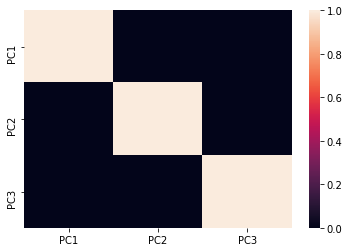

In [24]:
sns.heatmap(df_pca.corr()) ## Heavily uncorrelated variables. Thus demonstrating the impact of PCA
plt.show()

### 3. Hopkin's test

In [25]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [26]:
hopkins(df_pca)

0.8256841655623359

The Hopkins statistic indicates the clustering tendency of the dataset

A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

#### Our dataset is having a very high hopkin's value around 0.8, thus indicating very strong cluster tendency.

### 4. Model Building

Both K-means and Hierarchical clustering are used on this dataset to create clusters.

## K- Means Clustering
The basic step in K-Means is to identify the number of clusters we want to form. 2 methods which can help us in doing so are 
- Silhouette Score
- Elbow Curve

#### Silhouette Score

For n_clusters=2, the silhouette score is 0.5185558823979908
For n_clusters=3, the silhouette score is 0.4752489879439526
For n_clusters=4, the silhouette score is 0.38201960907232024
For n_clusters=5, the silhouette score is 0.3872164372867597
For n_clusters=6, the silhouette score is 0.37024183771449093
For n_clusters=7, the silhouette score is 0.4082484207171981
For n_clusters=8, the silhouette score is 0.41806641652976545


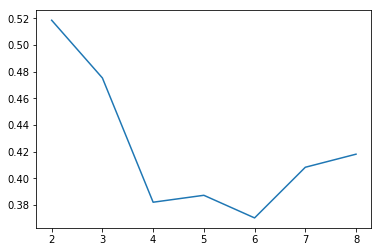

In [27]:
ssd=[]
for i in range(2,9):
    kmeans=KMeans(n_clusters=i,max_iter=50,random_state=100)
    kmeans.fit(df_pca)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(i, silhouette_avg))
    ssd.append([i,silhouette_avg])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])
plt.show()

#### Elbow Curve

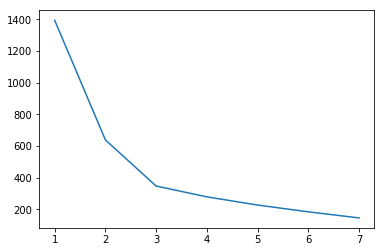

In [28]:
ssd = []
for num_clusters in list(range(1,8)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50,random_state= 100)
    model_clus.fit(df_pca)
    ssd.append((num_clusters,model_clus.inertia_))

plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])
plt.show()

From the graphs, it looks like we can select 3 or 4 clusters.

In [29]:
#Let's perform K means using K=4
model=KMeans(n_clusters=4,random_state=100)
model.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=100, tol=0.0001, verbose=0)

In [30]:
model.labels_

array([0, 2, 2, 0, 3, 2, 2, 1, 1, 2, 3, 3, 2, 3, 2, 1, 2, 0, 2, 2, 2, 0,
       2, 1, 3, 0, 0, 2, 0, 1, 2, 0, 0, 3, 2, 2, 0, 0, 0, 3, 0, 3, 1, 3,
       1, 2, 2, 2, 2, 0, 0, 3, 2, 1, 1, 0, 0, 2, 1, 0, 3, 2, 2, 0, 0, 2,
       0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 3, 3, 0,
       0, 3, 3, 1, 2, 0, 0, 3, 3, 0, 1, 0, 3, 2, 2, 2, 3, 2, 0, 2, 0, 2,
       1, 3, 0, 0, 1, 3, 0, 3, 2, 2, 2, 3, 3, 1, 3, 2, 0, 2, 3, 0, 2, 3,
       0, 1, 3, 3, 0, 2, 3, 3, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 1, 1, 3, 2, 2, 2, 2, 0, 0])

In [31]:
df_pca_kmeans=df_pca.copy() #Copy of pca dataset
df_pca_kmeans['ClusterID']=model.labels_
df_pca_kmeans['country']=country

#### Cluster Analysis

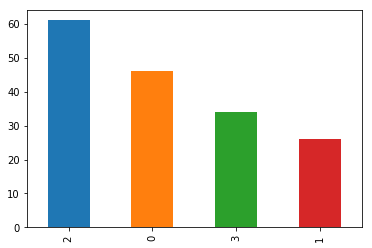

In [32]:
df_pca_kmeans.ClusterID.value_counts().plot(kind='bar')
plt.show()

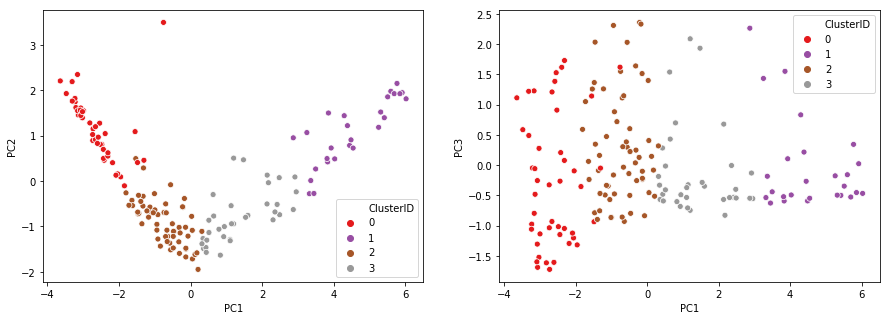

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'ClusterID', data = df_pca_kmeans, palette='Set1')

plt.subplot(1,2,2)
sns.scatterplot(x = 'PC1', y = 'PC3', hue = 'ClusterID', data = df_pca_kmeans, palette='Set1')
plt.show() 
#Little to no overlapp and clearly definitive clusters

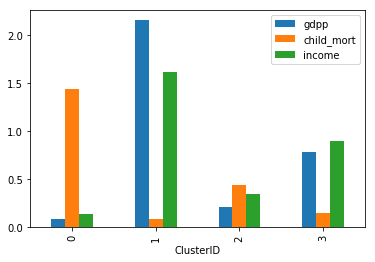

In [34]:
df_kmeans=df.copy() # Copy of the actual dataset
df_kmeans['ClusterID']=model.labels_
temp=df_kmeans[['gdpp','child_mort','income']].apply(lambda x:x/x.sum()*100)
temp['ClusterID']=df_kmeans['ClusterID']
temp[['gdpp','child_mort','income','ClusterID']].groupby('ClusterID').mean().plot(kind = 'bar')
plt.show()

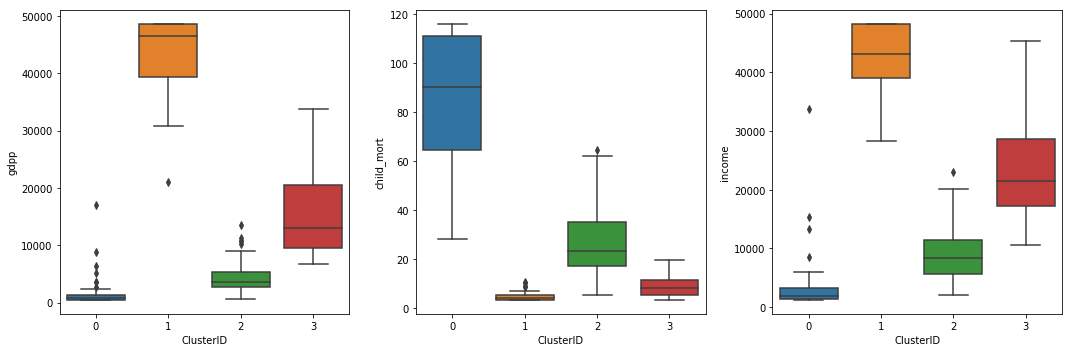

In [35]:
col=['gdpp','child_mort','income']
plt.figure(figsize=(15,5))
for i,j in enumerate(col):
    plt.subplot(1,3,i+1)
    sns.boxplot(data=df_kmeans,x='ClusterID',y=j)
plt.tight_layout()

#### Inference:

- gdpp is the lowest for clusters 0 and 2
- child mortality is the highest for cluster 0 
- income is the lowest for cluster 0
- Countries belonging to cluster 0 are the one's in dire need of help. Followed by cluster 2.
- Countries in Cluster 1 are the most well off
- Select countries with childmortality > 90 and gdpp<600

In [36]:
t_kmeans=df_kmeans[df_kmeans['ClusterID']==0] # Selecting cluster 0
t_kmeans=t_kmeans[(t_kmeans['child_mort']>=90) & (t_kmeans['gdpp']<600)] # countries with childmortality > 90 and gdpp<600
t_kmeans#These are the countries in need of help from k-means

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,70.4688,41.91740,248.297,1610.0,9.44,56.20,5.820,553.0,0
25,Burkina Faso,116.0,110.4000,38.75500,170.200,1430.0,6.81,57.90,5.861,575.0,0
26,Burundi,93.6,70.4688,26.79600,169.281,1213.0,12.30,57.70,5.861,465.9,0
31,Central African Republic,116.0,70.4688,26.71592,169.281,1213.0,2.01,55.78,5.210,465.9,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.71592,169.281,1213.0,20.80,57.50,5.861,465.9,0
64,Guinea-Bissau,114.0,81.5030,46.49500,192.544,1390.0,2.97,55.78,5.050,547.0,0
94,Malawi,90.5,104.6520,30.24810,169.281,1213.0,12.10,55.78,5.310,465.9,0
106,Mozambique,101.0,131.9850,26.71592,193.578,1213.0,7.64,55.78,5.560,465.9,0
112,Niger,116.0,77.2560,26.71592,170.868,1213.0,2.55,58.80,5.861,465.9,0
132,Sierra Leone,116.0,70.4688,52.26900,169.281,1220.0,17.20,55.78,5.200,465.9,0


## Hierarchial Clustering
The major drawback of kmeans is that we have to select the number of clusters beforehand. 
Hierarchial clustering is of 2 types; Agglomerative clustering(Bottom up approach) and Divisive clustering(top down approach), and in that Agglomerative clustering can be further split up into:
- Single Linkage : the distance between 2 clusters is defined as the shortest distance between points in the two clusters
- Complete Linkage :the distance between 2 clusters is defined as the maximum distance between any 2 points in the clusters
- Average Linkage :the distance between 2 clusters is defined as the average distance between every point of one cluster to every other point of the other cluster.

For our analysis, we will be considering Single Linkage and Complete Linkage Agglomerative clustering. _Hierarchial clustering algorithms are very exhaustive and time consuming; which is why k-means is the more popular technique._

#### Single Linkage

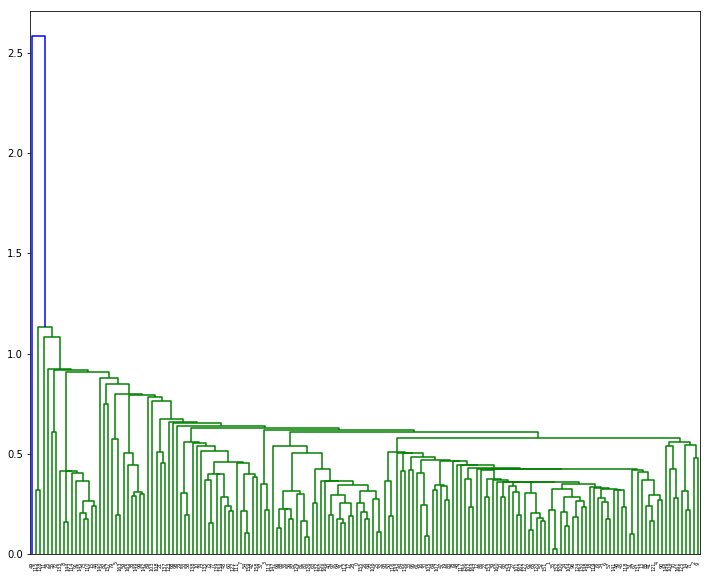

In [37]:
plt.figure(figsize=(12,10))
single=linkage(df_pca,method='single',metric='euclidean')
dendrogram(single)
plt.show() # The dendrogram is not producing good enough results for us to analyse.

#### Complete Linkage

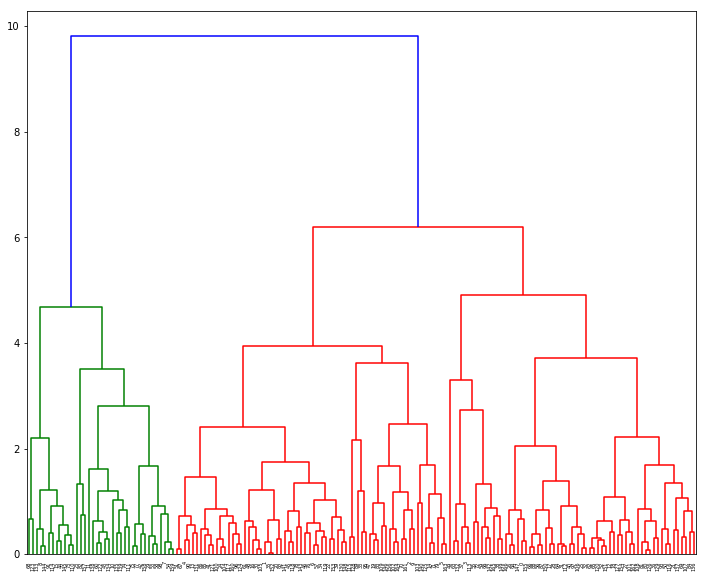

In [38]:
plt.figure(figsize=(12,10))
complete=linkage(df_pca,method='complete',metric='euclidean')
dendrogram(complete)
plt.show()

In [39]:
## Cut the tree at height nearly 6 to get 3 clusters.
cluster_complete=cut_tree(complete,n_clusters=3)
df_pca_complete=df_pca.copy() # Taking copy of pca dataset
df_pca_complete['ClusterID']=cluster_complete
df_pca_complete.head()

,PC1,PC2,PC3,ClusterID
0,-3.131864,1.546735,-0.481322,0
1,-0.131783,-1.671861,-0.100295,1
2,-0.740848,-0.690890,1.551370,1
3,-3.160768,2.351711,1.228626,0
4,0.946167,-1.002425,-0.488946,1


#### Cluster Analysis

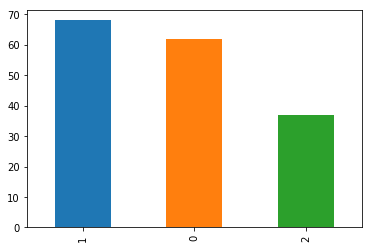

In [40]:
df_pca_complete.ClusterID.value_counts().plot(kind='bar')
plt.show()

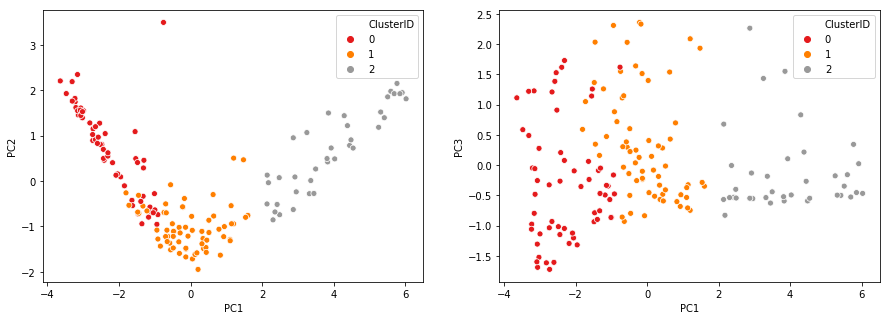

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'ClusterID', data = df_pca_complete, palette='Set1')

plt.subplot(1,2,2)
sns.scatterplot(x = 'PC1', y = 'PC3', hue = 'ClusterID', data = df_pca_complete, palette='Set1')
plt.show() 
# Clusters are clearly defined with very little overlapp

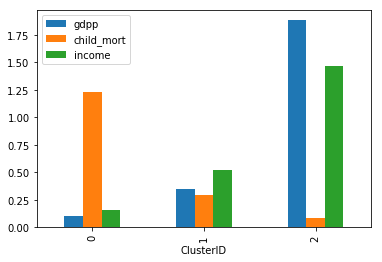

In [42]:
df_complete=df.copy() # Copy ofthe original dataset
df_complete['ClusterID']=cluster_complete
temp=df_complete[['gdpp','child_mort','income']].apply(lambda x:x/x.sum()*100)
temp['ClusterID']=df_complete['ClusterID']
temp[['gdpp','child_mort','income','ClusterID']].groupby('ClusterID').mean().plot(kind = 'bar')
plt.show()

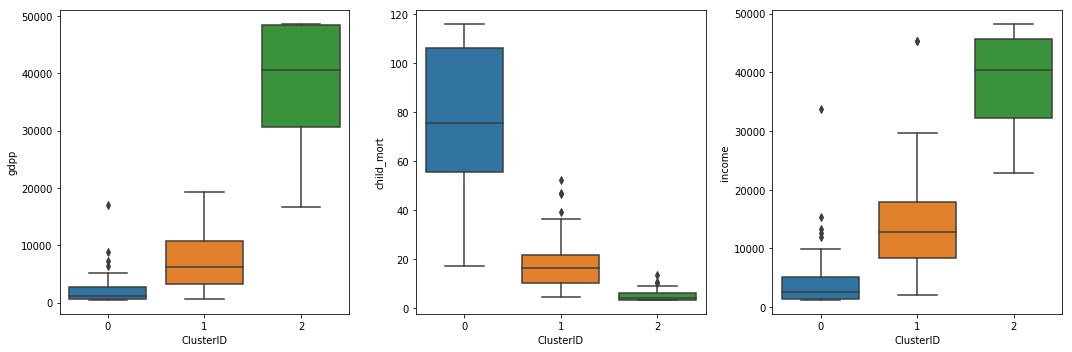

In [43]:
col=['gdpp','child_mort','income']
plt.figure(figsize=(15,5))
for i,j in enumerate(col):
    plt.subplot(1,3,i+1)
    sns.boxplot(data=df_complete,x='ClusterID',y=j)
plt.tight_layout()

#### Inference:
- Obviously cluster 0 is the worst performer and cluster 2 is the best.
- We need to focus on contries in cluster 0 to indentify the one's in need.
- Most of the countries are in 0 and 1. Thus indicating that only a small portion of the population are well off
- My approach is to take the one's common from cluster 0 of kmeans and cluster 0 of complete linkage algorithms.

In [44]:
t_complete=df_complete[df_complete['ClusterID']==0]
t_complete=t_complete[(t_complete['child_mort']>=90) & (t_complete['gdpp']<600)]
t_complete

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,70.4688,41.91740,248.297,1610.0,9.44,56.20,5.820,553.0,0
25,Burkina Faso,116.0,110.4000,38.75500,170.200,1430.0,6.81,57.90,5.861,575.0,0
26,Burundi,93.6,70.4688,26.79600,169.281,1213.0,12.30,57.70,5.861,465.9,0
31,Central African Republic,116.0,70.4688,26.71592,169.281,1213.0,2.01,55.78,5.210,465.9,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.71592,169.281,1213.0,20.80,57.50,5.861,465.9,0
64,Guinea-Bissau,114.0,81.5030,46.49500,192.544,1390.0,2.97,55.78,5.050,547.0,0
94,Malawi,90.5,104.6520,30.24810,169.281,1213.0,12.10,55.78,5.310,465.9,0
106,Mozambique,101.0,131.9850,26.71592,193.578,1213.0,7.64,55.78,5.560,465.9,0
112,Niger,116.0,77.2560,26.71592,170.868,1213.0,2.55,58.80,5.861,465.9,0
132,Sierra Leone,116.0,70.4688,52.26900,169.281,1220.0,17.20,55.78,5.200,465.9,0


In [45]:
set(t_kmeans.country).union(set(t_complete.country)) # Both kmeans and hierarchical clustering has reported back the same
# set of countries as the one's in dire need.

{'Afghanistan',
 'Burkina Faso',
 'Burundi',
 'Central African Republic',
 'Congo, Dem. Rep.',
 'Guinea-Bissau',
 'Malawi',
 'Mozambique',
 'Niger',
 'Sierra Leone',
 'Togo'}

## Conclusion

From the initial Heatmaps and pairplots, it was evident that the majority of features were heavily correlated and hence does'nt add additional informations which calls for the need of dimensionality reduction using PCA. By analysing the clusters formed from Kmeans and Hierarchical clustering, we pin pointed the countries which are performing the poorest; mainly by cross-checking how the clusters performed against predominant features such as *child mortality, income and gdpp*.

Countries the NGO should focus on helping are :
- 'Afghanistan',
- 'Burkina Faso',
- 'Burundi',
- 'Central African Republic',
- 'Congo, Dem. Rep.',
- 'Guinea-Bissau',
- 'Malawi',
- 'Mozambique',
- 'Niger',
- 'Sierra Leone',
- 'Togo'